In [1]:
import torch
from torch import optim, save
from torchvision import datasets, transforms
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from IPython import display
from matplotlib.colors import ListedColormap
# import lipmip.utilities as utils
# from lipmip.relu_nets import ReLUNet
# from lipmip.hyperbox import Hyperbox 
# import lipmip.interval_analysis as ia 
# from lipmip.lipMIP import LipMIP
import numpy as np

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.betavae import MnistVAE

In [3]:
bs = 200

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
# load and train BigVAE
# nc = 1
# nz = 8
# ndf = 16
# ngf = 16
beta = 1
# hparams_vae = {"nc": nc, "nz": nz, "ndf": ndf, "ngf": ngf}
# vae = BigVAE(hparams_vae)
# vae.cuda()

# Load and train SmallVAE
vae = MnistVAE({"nz": 8})
vae.cuda()

MnistVAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (_decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride

In [8]:
vae.load_state_dict(torch.load("saved_models/mnist_beta3_vae.pt"))

<All keys matched successfully>

In [9]:
classes = ['White', 'Black', 'Asian', 'Indian', 'Others'] # UTKFace
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#values = [0, 1]
colours = ListedColormap(['#1988F7', '#D9A464', '#28FC92', '#36EBE5', '#E6407A', '#00AAEF', '#BC00EF', '#EF4500', '#32EF00', '#EF00AA'])

In [17]:
emb_dims = 8
ls = np.array([np.zeros(emb_dims)])
y = np.array([0])
for data, label in train_loader:
    img = data.cuda()
    z, _ = vae.encode(img)
    ls = np.append(ls, z[:, :emb_dims].detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    scatter = plt.scatter(ls[:, 0], ls[:, 3], c=y, cmap=colours, alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.pause(0.1)
    #if ls.shape[0] > 5000:
    #    break

KeyboardInterrupt: 

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

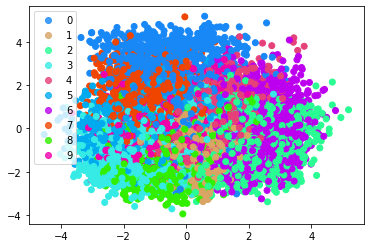

In [19]:
pca = PCA(2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(ls)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

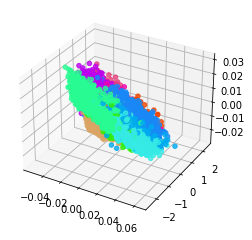

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(ls[:, 5], ls[:, 6], ls[:,3], c=y, cmap=colours, alpha=0.8)

In [22]:
with torch.no_grad():
    z = torch.randn(64, 8).cuda()
    sample = vae.decode(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/mnist_sample_' + '.png')

In [12]:
ls[:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.81819159e-03,  5.84258139e-03, -2.22827948e-04,
        -4.45459068e-01,  3.12346965e-04, -2.05060281e-03,
         1.00850575e-02, -1.16598755e-02],
       [ 2.29854509e-02, -5.15398756e-03, -2.48027197e-03,
        -6.22293949e-01,  5.76166436e-04, -4.01596911e-03,
         1.91445239e-02, -1.61414817e-02],
       [-9.09395516e-04,  4.71886247e-03, -7.69816048e-04,
        -3.77928376e-01, -4.92113829e-03,  1.32837705e-03,
         7.86987692e-03, -9.03557241e-03],
       [ 6.65432960e-03,  9.47073102e-04, -1.18059739e-02,
         1.77078772e+00,  2.31254958e-02, -9.91147943e-03,
        -1.71997957e-02,  2.30733827e-02],
       [-1.79946423e-03,  6.06697612e-03, -4.53035987e-04,
        -2.93676555e-01, -7.33537041e-03,  2.35539116e-03,
         7.89565966e-03, -5.43949055e-03],
       [ 9.37899202e-03,  5.772747